In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor

In [ ]:
# ----------------------------
# Load Data
# ----------------------------

# --------------------------
# 1. Load and Merge Datasets
# --------------------------
train = pd.read_csv("/content/drive/MyDrive/zillow-prize-1/train_2016_v2.csv")
properties = pd.read_csv("/content/drive/MyDrive/zillow-prize-1/properties_2016.csv")
data = pd.merge(train, properties, how="left", on="parcelid")

<ipython-input-4-2858abe483fc>:9: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  properties = pd.read_csv("/content/drive/MyDrive/zillow-prize-1/properties_2016.csv")


In [ ]:
# ----------------------------
# Feature Engineering & Cleaning
# ----------------------------
df = data.copy()


# Drop outliers in logerror (optional)
df = df[df['logerror'] > -0.4]
df = df[df['logerror'] < 0.419]

# Drop features with too many missing values
missing = df.isnull().sum() / len(df)
to_drop = missing[missing > 0.5].index.tolist()
df = df.drop(columns=to_drop)

# Fill missing values
print("Handling missing values...")
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('Missing')
    else:
        df[col] = df[col].fillna(df[col].mean())

# Label encode categorical variables
print("Encoding categorical features...")
for col in df.columns:
    if df[col].dtype == 'object':
        lbl = LabelEncoder()
        df[col] = lbl.fit_transform(df[col].astype(str))

# Drop non-feature columns
non_features = ['parcelid', 'logerror', 'transactiondate']
X = df.drop(columns=non_features)
y = df['logerror']

Handling missing values...
Encoding categorical features...


In [ ]:
# ----------------------------
# Train-Test Split
# ----------------------------
print("Splitting into train/validation sets...")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Splitting into train/validation sets...


In [ ]:
# ----------------------------
# Linear Regression Model
# ----------------------------
import numpy as np
print("Training Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_val)
lr_mae = mean_absolute_error(y_val, lr_preds)
print(f"Linear Regression MAE: {lr_mae:.5f}")


# Compute Pearson correlation coefficient
correlation_xgb = np.corrcoef(y_val, lr_preds)[0, 1]
print(f"Correlation between actual and predicted logerror: {correlation_xgb:.5f}")

# ----------------------------
# XGBoost Model (Initial)
# ----------------------------
print("Training XGBoost Regressor...")
xgb = XGBRegressor(n_estimators=250, learning_rate=0.05, max_depth=7, random_state=42, verbosity=1)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_val)
xgb_mae = mean_absolute_error(y_val, xgb_preds)
print(f"Initial XGBoost MAE: {xgb_mae:.5f}")

# ----------------------------
# Hyperparameter Tuning
# ----------------------------
print("Starting RandomizedSearchCV for XGBoost...")
param_grid = {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

random_search = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Best model
best_xgb = random_search.best_estimator_
best_preds = best_xgb.predict(X_val)
best_mae_xgb = mean_absolute_error(y_val, best_preds)
print(f"Tuned XGBoost MAE: {best_mae_xgb:.5f}")


Training Linear Regression...
Linear Regression MAE: 0.05376
Correlation between actual and predicted logerror: 0.09766
Training XGBoost Regressor...
Initial XGBoost MAE: 0.05356
Starting RandomizedSearchCV for XGBoost...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Tuned XGBoost MAE: 0.05343


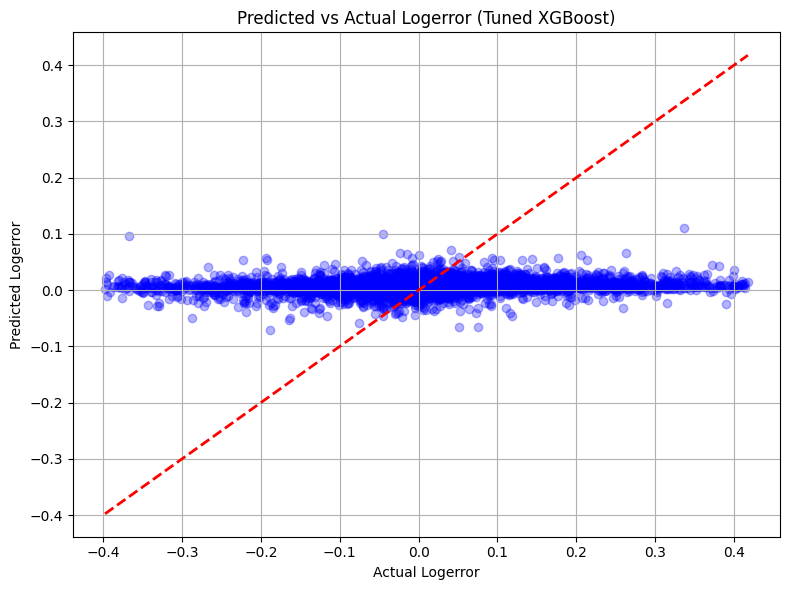

In [ ]:
import matplotlib.pyplot as plt

# Plot: Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y_val, best_preds, alpha=0.3, color='blue')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Logerror')
plt.ylabel('Predicted Logerror')
plt.title('Predicted vs Actual Logerror (Tuned XGBoost)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Compute Pearson correlation coefficient
correlation_xgb = np.corrcoef(y_val, best_preds)[0, 1]
print(f"Correlation between actual and predicted logerror: {correlation_xgb:.5f}")


Correlation between actual and predicted logerror: 0.15270


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error

# ----------------------------
# CatBoost Model
# ----------------------------
print("Training CatBoost Regressor...")

# Convert to CatBoost Pool (better performance & handles categorical encoding internally)
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

# Initialize CatBoost with basic parameters
catboost_model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MAE',
    eval_metric='MAE',
    verbose=100,
    random_seed=42
)

# Train
catboost_model.fit(train_pool, eval_set=val_pool)

# Predict and evaluate
cat_preds = catboost_model.predict(X_val)
cat_mae = mean_absolute_error(y_val, cat_preds)
print(f"CatBoost MAE: {cat_mae:.5f}")


Training CatBoost Regressor...
0:	learn: 0.0530658	test: 0.0538885	best: 0.0538885 (0)	total: 168ms	remaining: 1m 24s
100:	learn: 0.0522618	test: 0.0533405	best: 0.0533405 (100)	total: 7.5s	remaining: 29.6s
200:	learn: 0.0519187	test: 0.0532361	best: 0.0532361 (200)	total: 13.6s	remaining: 20.2s
300:	learn: 0.0515640	test: 0.0531646	best: 0.0531634 (298)	total: 20.4s	remaining: 13.5s
400:	learn: 0.0512358	test: 0.0531289	best: 0.0531287 (398)	total: 24.7s	remaining: 6.11s
499:	learn: 0.0509560	test: 0.0530963	best: 0.0530963 (499)	total: 26.8s	remaining: 0us

bestTest = 0.05309633507
bestIteration = 499

CatBoost MAE: 0.05310


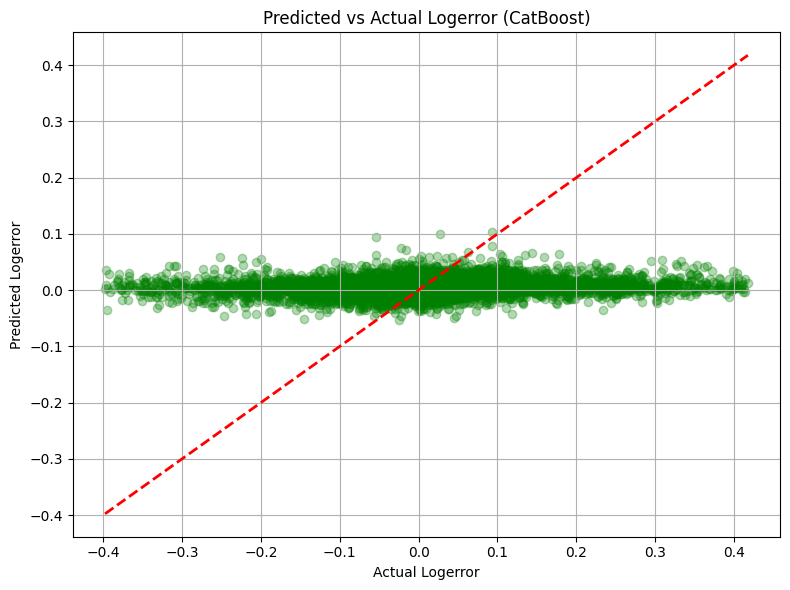

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, cat_preds, alpha=0.3, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Logerror')
plt.ylabel('Predicted Logerror')
plt.title('Predicted vs Actual Logerror (CatBoost)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
correlation_cat = np.corrcoef(y_val, cat_preds)[0, 1]
print(f"Correlation (CatBoost): {correlation_cat:.5f}")

Correlation (CatBoost): 0.15867


In [ ]:
pip install lightgbm

In [ ]:
import lightgbm as lgb

# ---------------------------------------------------
# Train LightGBM Regressor
# ---------------------------------------------------
print("Training LightGBM Regressor...")
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    metric='mae',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
early_stopping = lgb.callback.early_stopping(stopping_rounds=50)

lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[early_stopping])

# ---------------------------------------------------
# Predict and Evaluate
# ---------------------------------------------------
lgb_preds = lgb_model.predict(X_val)
lgb_mae = mean_absolute_error(y_val, lgb_preds)


print(f"LightGBM MAE: {lgb_mae:.5f}")



Training LightGBM Regressor...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3795
[LightGBM] [Info] Number of data points in the train set: 70822, number of used features: 27
[LightGBM] [Info] Start training from score 0.007860
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[158]	valid_0's l1: 0.0532717
LightGBM MAE: 0.05327


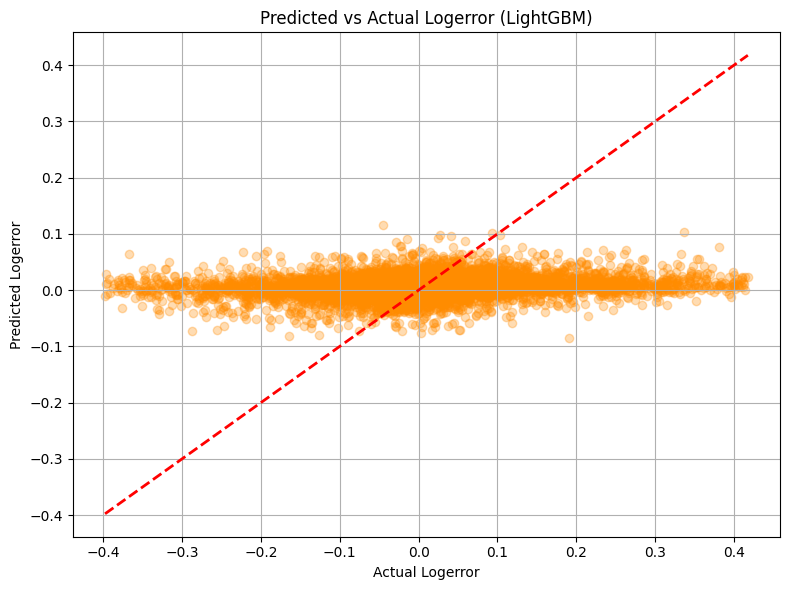

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_val, lgb_preds, alpha=0.3, color='darkorange')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Logerror')
plt.ylabel('Predicted Logerror')
plt.title('Predicted vs Actual Logerror (LightGBM)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
lgb_corr = np.corrcoef(y_val, lgb_preds)[0, 1]
print(f"LightGBM Correlation: {lgb_corr:.5f}")

LightGBM Correlation: 0.17462


In [ ]:
#Stacking Model (RF + XGBoost)
# Assume X and y are already preprocessed as before
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ----------------------------
# Define Base Models
# ----------------------------
xgb_model = XGBRegressor(
    n_estimators=250,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

# ----------------------------
# Define Stacking Regressor
# ----------------------------
stack_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model)
    ],
    final_estimator=LinearRegression(),  # Meta-learner
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# ----------------------------
# Train the Stacking Model
# ----------------------------
print("Training Stacking Regressor...")
stack_model.fit(X_train, y_train)

# Predict & Evaluate
stack_preds = stack_model.predict(X_val)
stack_mae_xgb = mean_absolute_error(y_val, stack_preds)
print(f"Stacked Model MAE(XGB + RF): {stack_mae_xgb:.5f}")

Training Stacking Regressor...
Stacked Model MAE(XGB + RF): 0.05376


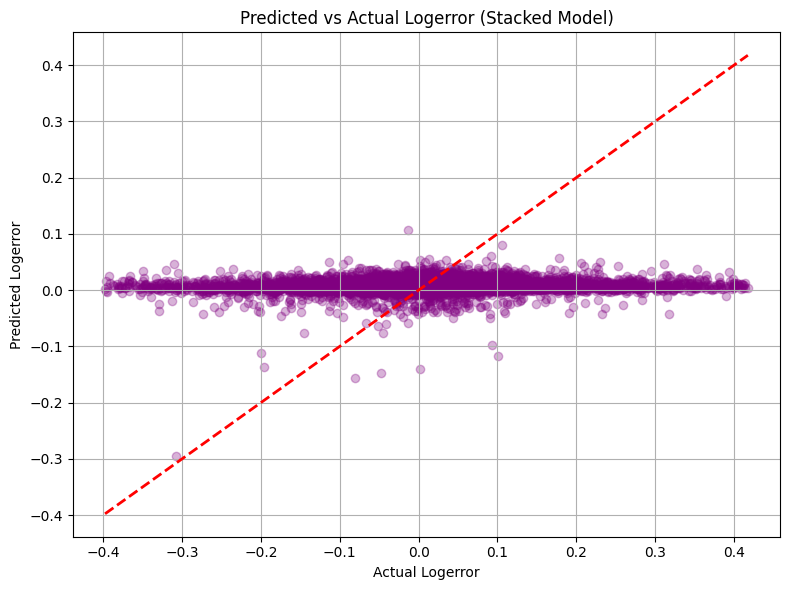

In [ ]:
# ----------------------------
# Plot Predictions
# ----------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_val, stack_preds, alpha=0.3, color='purple')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Logerror')
plt.ylabel('Predicted Logerror')
plt.title('Predicted vs Actual Logerror (Stacked Model)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------
# Correlation Coefficient
# ----------------------------
stack_corr_xgb = np.corrcoef(y_val, stack_preds)[0, 1]
print(f"Stacked Model Correlation: {stack_corr_xgb:.5f}")

Stacked Model Correlation: 0.09766


In [ ]:
from catboost import CatBoostRegressor, Pool
# ---------------------------------------------
# Train-Test Split (if not already done)
# ---------------------------------------------
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ---------------------------------------------
# Define Base Models
# ---------------------------------------------
catboost_model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    loss_function='MAE',
    verbose=0,
    random_seed=42
)

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

# ---------------------------------------------
# Define Stacking Regressor
# ---------------------------------------------
stacked_model = StackingRegressor(
    estimators=[
        ('catboost', catboost_model),
        ('rf', rf_model)
    ],
    final_estimator=LinearRegression(),
    passthrough=True,
    cv=5,
    n_jobs=-1
)

# ---------------------------------------------
# Train Stacking Model
# ---------------------------------------------
print("Training CatBoost + RF Stacking Model...")
stacked_model.fit(X_train, y_train)

# ---------------------------------------------
# Evaluate
# ---------------------------------------------
stacked_preds = stacked_model.predict(X_val)
stacked_mae_cat = mean_absolute_error(y_val, stacked_preds)
print(f"Stacked Model MAE(CatBoost + RF): {stacked_mae_cat:.5f}")

Training CatBoost + RF Stacking Model...
Stacked Model MAE(CatBoost + RF): 0.05376


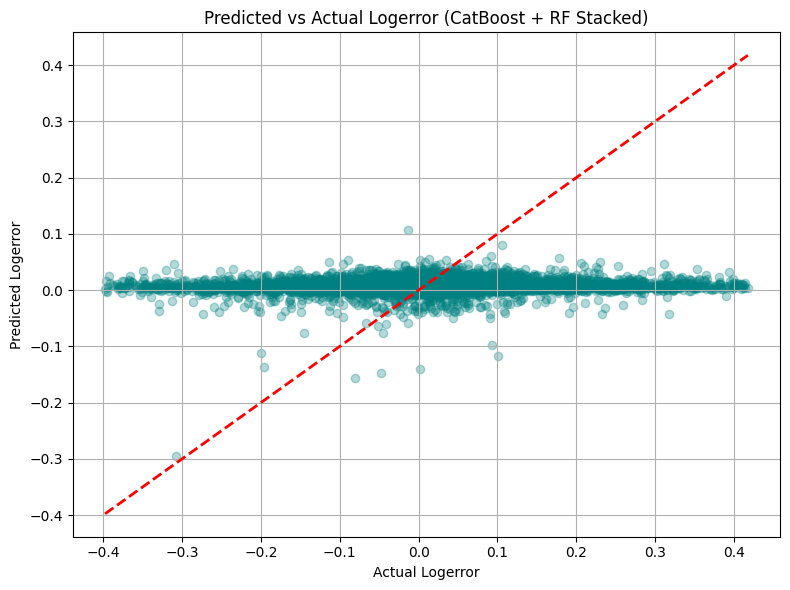

In [ ]:
# ---------------------------------------------
# Plot Predicted vs Actual
# ---------------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_val, stacked_preds, alpha=0.3, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Logerror')
plt.ylabel('Predicted Logerror')
plt.title('Predicted vs Actual Logerror (CatBoost + RF Stacked)')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# ----------------------------
# Correlation Coefficient
# ----------------------------
stacked_corr_cat = np.corrcoef(y_val, stacked_preds)[0, 1]
print(f"Stacked Model Correlation: {stacked_corr_cat:.5f}")

Stacked Model Correlation: 0.09766


In [ ]:
# ---------------------------------------------------
# Define Base Models
# ---------------------------------------------------
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    metric='mae',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

# ---------------------------------------------------
# Define Stacking Regressor
# ---------------------------------------------------
stacked_model = StackingRegressor(
    estimators=[
        ('lightgbm', lgb_model),
        ('rf', rf_model)
    ],
    final_estimator=LinearRegression(),
    passthrough=True,
    cv=5,
    n_jobs=-1
)

# ---------------------------------------------------
# Train Stacked Model
# ---------------------------------------------------
print("Training Stacked LightGBM + RF Model...")
stacked_model.fit(X_train, y_train)

# ---------------------------------------------------
# Predict and Evaluate
# ---------------------------------------------------
stack_preds = stacked_model.predict(X_val)
stack_mae_lgb = mean_absolute_error(y_val, stack_preds)


print(f"Stacked LightGBM + RF MAE: {stack_mae_lgb:.5f}")

Training Stacked LightGBM + RF Model...
Stacked LightGBM + RF MAE: 0.05376


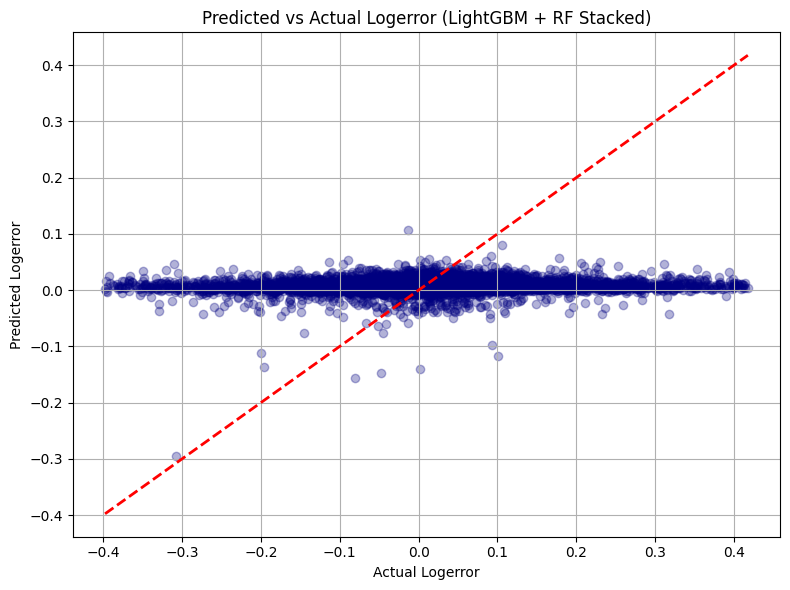

In [ ]:
# ---------------------------------------------------
# Plot Predicted vs Actual
# ---------------------------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(y_val, stack_preds, alpha=0.3, color='navy')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Logerror')
plt.ylabel('Predicted Logerror')
plt.title('Predicted vs Actual Logerror (LightGBM + RF Stacked)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
stack_corr_lgb = np.corrcoef(y_val, stack_preds)[0, 1]
print(f"Stacked Correlation: {stack_corr_lgb:.5f}")

Stacked Correlation: 0.09766


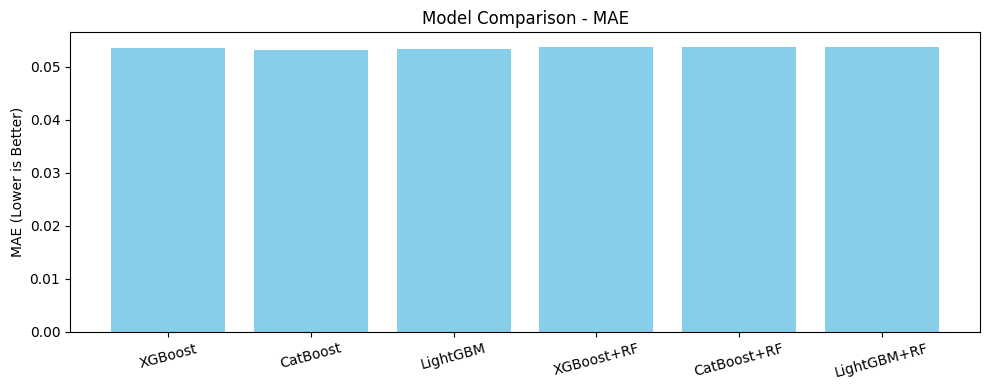

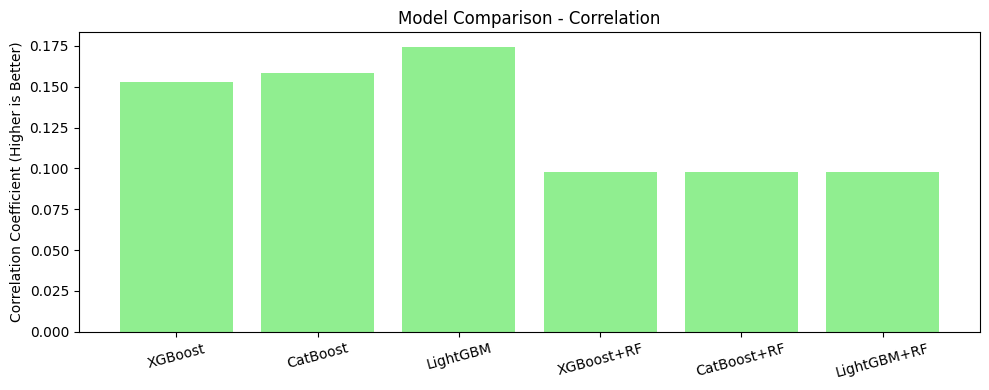

In [ ]:
import matplotlib.pyplot as plt

models = ['XGBoost', 'CatBoost', 'LightGBM', 'XGBoost+RF', 'CatBoost+RF', 'LightGBM+RF']
maes =    [best_mae_xgb, cat_mae, lgb_mae, stack_mae_xgb, stacked_mae_cat, stack_mae_lgb]
corrs =   [correlation_xgb, correlation_cat, lgb_corr, stack_corr_xgb, stacked_corr_cat, stack_corr_lgb]

# MAE Bar Plot
plt.figure(figsize=(10, 4))
plt.bar(models, maes, color='skyblue')
plt.ylabel('MAE (Lower is Better)')
plt.title('Model Comparison - MAE')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Correlation Plot
plt.figure(figsize=(10, 4))
plt.bar(models, corrs, color='lightgreen')
plt.ylabel('Correlation Coefficient (Higher is Better)')
plt.title('Model Comparison - Correlation')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


In [ ]:
# ----------------------------
# Prepare Final Predictions
# ----------------------------
print("Preparing final predictions...")
properties = pd.read_csv('/content/drive/MyDrive/zillow-prize-1/properties_2016.csv')

# Keep only the columns that were used in training
properties = properties[[col for col in X_train.columns if col in properties.columns]]

# Fill missing and encode again for test data, using the same logic as training data
for col in properties.columns:
    if properties[col].dtype == 'object':
        properties[col] = properties[col].fillna('Missing')
        lbl = LabelEncoder()
        # Ensure the label encoder is fitted on the same values as in training data
        # For consistency, fit it with all unique values from both training and testing data
        lbl.fit(pd.concat([df[col], properties[col]]).astype(str).unique())
        properties[col] = lbl.transform(properties[col].astype(str))
    else:
        properties[col] = properties[col].fillna(df[col].mean())  # Use training data mean for consistency

X_test = properties.drop(columns=['parcelid'], errors='ignore')

# Ensure the columns in X_test are in the same order as X_train
X_test = X_test[X_train.columns]

early_stopping = lgb.callback.early_stopping(stopping_rounds=50)
lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=[early_stopping])

# ----------------------------
# Predict on Test Data using LightGBM
# ----------------------------
final_preds = lgb_model.predict(X_test)

# -------------------------
# Create Submission File
# -------------------------
properties2 = pd.read_csv('/content/drive/MyDrive/zillow-prize-1/properties_2016.csv', low_memory=False)

print("Creating submission file with month-wise variations...")

submission = pd.DataFrame({
    'ParcelId': properties2['parcelid'],
    '201610': final_preds + 0.002,
    '201611': final_preds + 0.004,
    '201612': final_preds + 0.006,
    '201710': final_preds - 0.002,
    '201711': final_preds - 0.004,
    '201712': final_preds
})

submission.to_csv('submission.csv', index=False)
print("Submission saved as submission.csv!")

Preparing final predictions...


<ipython-input-35-6eff4eae2ed1>:5: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  properties = pd.read_csv('/content/drive/MyDrive/zillow-prize-1/properties_2016.csv')
<ipython-input-35-6eff4eae2ed1>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties[col] = properties[col].fillna(df[col].mean())  # Use training data mean for consistency


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3795
[LightGBM] [Info] Number of data points in the train set: 70822, number of used features: 27
[LightGBM] [Info] Start training from score 0.007860
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[158]	valid_0's l1: 0.0532717
Creating submission file with month-wise variations...
Submission saved as submission.csv!


In [ ]:
import pandas as pd

# Load submission file
submission = pd.read_csv("submission.csv")

# Display first 5 rows
print(submission.head())

   ParcelId    201610    201611    201612    201710    201711    201712
0  10754147  0.027368  0.029368  0.031368  0.023368  0.021368  0.025368
1  10759547 -0.028294 -0.026294 -0.024294 -0.032294 -0.034294 -0.030294
2  10843547  0.038348  0.040348  0.042348  0.034348  0.032348  0.036348
3  10859147  0.031684  0.033684  0.035684  0.027684  0.025684  0.029684
4  10879947 -0.021119 -0.019119 -0.017119 -0.025119 -0.027119 -0.023119
